# Psycholinguistic classifier

In [178]:
%load_ext autoreload
%autoreload 2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier, XGBRegressor

from matplotlib import pyplot as plt
%matplotlib inline  

from data import Data

import pandas as pd

import numpy as np

import kenlm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import nltk

In [35]:
from nltk import wordnet as wn
wn.wordnet.synsets('house')

[Synset('house.n.01'),
 Synset('firm.n.01'),
 Synset('house.n.03'),
 Synset('house.n.04'),
 Synset('house.n.05'),
 Synset('house.n.06'),
 Synset('house.n.07'),
 Synset('sign_of_the_zodiac.n.01'),
 Synset('house.n.09'),
 Synset('family.n.01'),
 Synset('theater.n.01'),
 Synset('house.n.12'),
 Synset('house.v.01'),
 Synset('house.v.02')]

In [40]:
df = pd.read_csv('utils/Psycholinguistic_Features.txt', sep='\t')
df_mean = df.mean(axis=0)

lm_books = kenlm.LanguageModel('/Users/nathanhartmann/Downloads/model_books.lm')
lm_news = kenlm.LanguageModel('/Users/nathanhartmann/Downloads/model_news.lm')

training_data = ['datasets/english/News_Train.tsv',
                 'datasets/english/WikiNews_Train.tsv',
                 'datasets/english/Wikipedia_Train.tsv',
                ]
dev_data = ['datasets/english/News_Dev.tsv',
            'datasets/english/WikiNews_Dev.tsv',
            'datasets/english/Wikipedia_Dev.tsv'
           ]

In [41]:
data_train = Data()
data_train.load_data(training_data)

data_dev = Data()
data_dev.load_data(dev_data)

In [158]:
def get_lm(lm_books, lm_news, tokens):
    model = {'LM-Book_log10':0, 'LM-News_log10':0}    
    model['LM-Book_log10'] = lm_books.score(' '.join(tokens), bos=False, eos=False)
    model['LM-News_log10'] = lm_news.score(' '.join(tokens), bos=False, eos=False)
    return model

def get_psicolinguistics(df, df_mean, words):
    psicos = []
    for word in words:
        psico = {'Familiarity': 0, 'Age_of_Acquisition':0, 'Concreteness':0,'Imagery': 0}
        infos = df[df.Word == word]
        if not infos.empty:
            for key in psico.keys():
                psico[key] += infos[key].values[0]
        else:
            for key in psico.keys():
                psico[key] += df_mean[key]
        psicos.append(pd.Series(psico, index=psico.keys()))
    return pd.DataFrame(psicos).mean().to_dict()

def get_features(df, df_mean, lm_books, lm_news, instances):
    x = pd.DataFrame()
    for instance in instances:
        features = dict()
        tokens = [instance.tokens[i] for i in instance.target]
        features.update(get_psicolinguistics(df, df_mean, tokens))
        features.update(get_lm(lm_books, lm_news, tokens))
        x = x.append(pd.DataFrame([features]))
    return x.reset_index().drop('index', axis=1)

def print_roc(pred, y, message='Roc curve'):
    fpr, tpr, _ = roc_curve(y.ravel(), pred.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(message)
    plt.legend(loc="lower right")
    plt.show()

In [163]:
x_train = get_features(df, df_mean, lm_books, lm_news, data_train.instances)
y_train = np.array([instance.label[0] for instance in data_train.instances])

x_dev = get_features(df, df_mean, lm_books, lm_news, data_dev.instances)
y_dev = np.array([instance.label[0] for instance in data_dev.instances])

-----
# Predicting

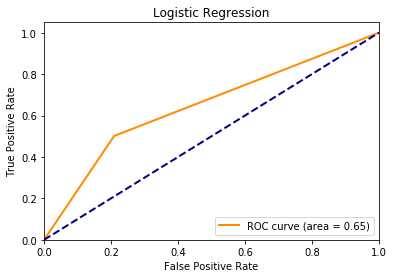

In [164]:
reg = LogisticRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_dev)
print_roc(pred, y_dev, 'Logistic Regression')

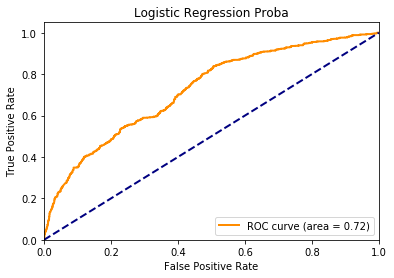

In [165]:
reg = LogisticRegression()
reg.fit(x_train, y_train)
pred = reg.predict_proba(x_dev)[:, 1:]
print_roc(pred, y_dev, 'Logistic Regression Proba')

/Users/nathanhartmann/Desktop/cwi-workshop/env/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


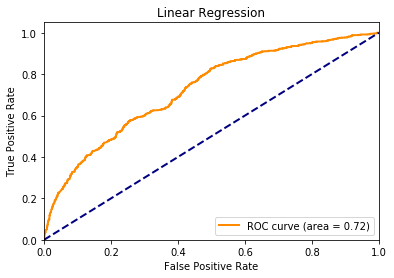

In [166]:
reg = LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_dev)
print_roc(pred, y_dev, 'Linear Regression')

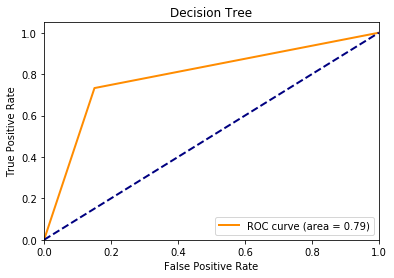

In [168]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
pred = tree.predict(x_dev)
print_roc(pred, y_dev, 'Decision Tree')

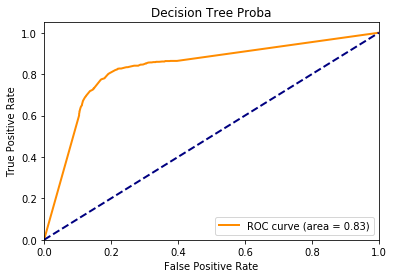

In [170]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
pred = tree.predict_proba(x_dev)[:, 1:]
print_roc(pred, y_dev, 'Decision Tree Proba')

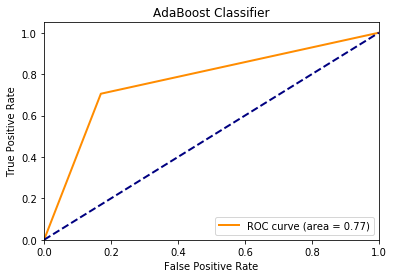

In [171]:
ensemb = AdaBoostClassifier()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'AdaBoost Classifier')

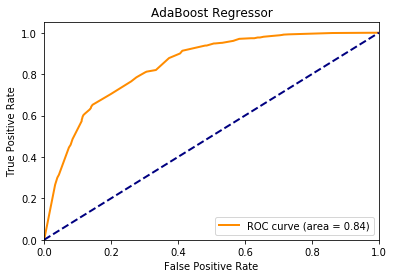

In [172]:
ensemb = AdaBoostRegressor()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'AdaBoost Regressor')

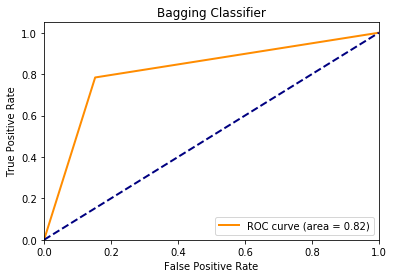

In [174]:
ensemb = BaggingClassifier()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'Bagging Classifier')

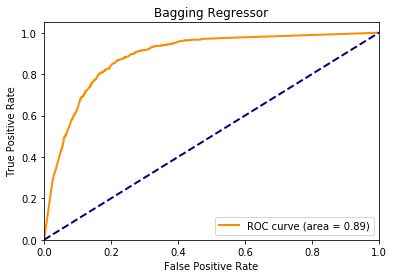

In [173]:
ensemb = BaggingRegressor()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'Bagging Regressor')

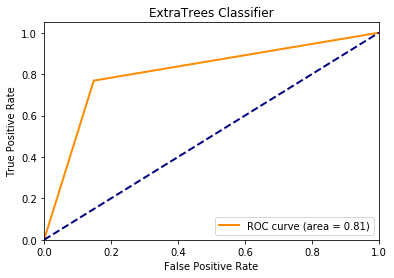

In [175]:
ensemb = ExtraTreesClassifier()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'ExtraTrees Classifier')

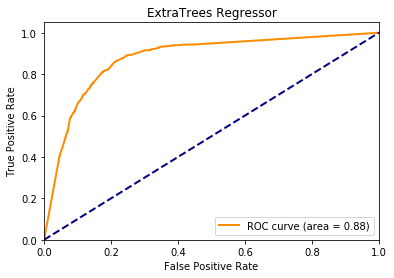

In [176]:
ensemb = ExtraTreesRegressor()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'ExtraTrees Regressor')

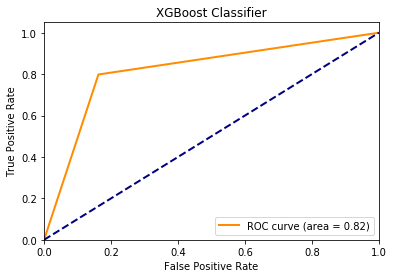

In [184]:
ensemb = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1)
ensemb.fit(x_train, y_train)
pred = ensemb.predict_proba(x_dev)[:]
print_roc(pred, y_dev, 'XGBoost Classifier')

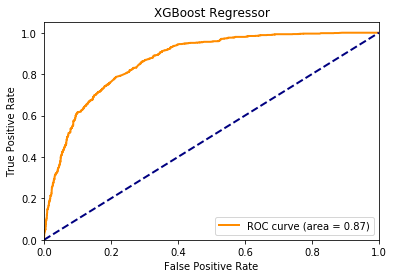

In [183]:
ensemb = XGBRegressor()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'XGBoost Regressor')

-----
# Tests

* target words not in psycholinguistic_features

In [110]:
# count = 0
# errors = []
# for instance in data_train.instances:
#     for target in instance.target:
#         try:
#             if len(df[df.Word == instance.tokens[target]].index) == 0:
#                 count += 1
#                 errors.append(instance.tokens[target])
#         except:
#             print(target, instance.target_chars, instance.tokens)
# print('%d / %d' % (count, len(data_train.instances)))
# print(list(set(errors)))

4014 / 27299
['', 'kabul', 'crackdown', 'goldenbridge', 'targeted', 'mla', 'amygdala', 'brevard', 'blek', 'teammate', 'jarvis', 'radars', 'cooperation', 'cernan', 'thumbs-up', 'stanković', 'gardner', 'luhman', 'bos', 'islamist', 'refinance', 'lockdown', 'tawam', 'kong', 'atropos', 'primetime', 'lt', 'bbc', 'dibenzenechromium', 'dvd', 'césar', 'organometallic', 'pompeii', 'asia', 'samsung', 'six-hour', 'nestmates', 'oriente', 'nasser', 'al-burnhanieh', 'london-based', 'iczn', 'perkasie', 'caspicara', 'maakond', 'itunes', 'pushkin', 'schengen', 'scm', 'brp', 'ibm', 'obamacare', 'moesian', 'pupates', 'kcvo', 'signings', 'premiered', 'kremlin-dominated', 'confusingly', 'choe', 'murad', 'karam', 'ex-soviet', 'primeiro', 'disabled/handicapped', 'fernando', 'worldwide', 'noorughli', 'doskozil', 'bosnia', 'mimar', 'eyewitnesses', 'kcb', 'timeline', 'psni', 'keita', 'rosenkavalier', '“', 'utc', 'hudson', 'gliese', 'favorites', 'shalygina', 'jaeg', 'six-point', 'thespis', 'temer', 'magherafelt',